
Fais tes modifs.

git add .

git commit -m "mon message"

git push origin main (ça envoie sur ton GitHub).

puis faire le pull recuest

Et pour récupérer le travail : git pull upstream main.

In [1]:
import numpy as np
from typing import Callable
import matplotlib.pyplot as plt


pi = np.pi
def cos(x: float) ->float:
    return np.cos(x)
def sin(x: float) ->float:
    return np.sin(x)

# Le problème

In [2]:
def D(x:float) -> float:
    return 1 + sin(x)/2

In [3]:
def f(x:float) -> float:
    return pi*cos(x)*sin(2*pi*x)+4*pi*pi*(1 + sin(x)/2)*cos(2*pi*x)

## Les conditions aux limites 

In [4]:
uO = 1
u1 = 1

## La solution Exact

In [5]:
def u_solution(x: float) -> float :
    return cos(2*pi*x)

# Discrétisation du problème

Posons le problème sous la forme AU = F

In [6]:
def A_constructor(N: int, D: Callable[[float], float]) -> np.ndarray :
    h = 1/N
    A = np.zeros((N-1, N-1), float)
    for i in range(N-1):
        for j in range(N-1):
            if i == j :
                A[i][j] = -N*N*(D((i+1/2)*h) + D((i-1/2)*h))
            elif i + 1 == j :
                A[i][j] = N*N*D((i+1/2)*h)
            elif i - 1 == j :
                A[i][j] = N*N*D((i-1/2)*h)
            else :
                A[i][j] = 0
    return A


In [7]:
def F_constructor(N: int, f: Callable[[float], float], D: Callable[[float], float], u0: float, u1: float) -> np.ndarray :
    h = 1/N
    F = np.zeros((N-1), float)
    for i in range(N-1):
        F[i] = f((i+1)*h)
        if i == 0 :
            F[i] -= N*N*D(1/(2*N))*u0
        elif i == N-2 :
            F[i] += N*N*D(((2*N-1)/(2*N)))*u1
    return F

Puis on inverse A pour trouver U

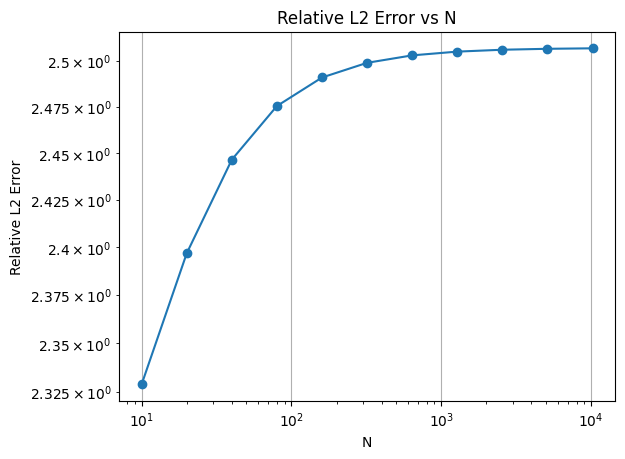

In [14]:
N_values = [10, 20, 40, 80, 160, 320, 640]
errors = []
for N in N_values:
    A = np.array(A_constructor(N, D), dtype=float)
    F = np.array(F_constructor(N, f, D, uO, u1), dtype=float)
    u_approx = np.linalg.solve(A, F)
    x_values = [(i)/N for i in range(N+1)]
    u_exact = [u_solution(x) for x in x_values]
    error2 = np.sqrt(sum([(u_approx[i-1] - u_exact[i])**2 for i in range(1, N)]))/np.sqrt(sum([u_exact[i]**2 for i in range(N+1)]))
    errors.append(error2)
plt.loglog(N_values, errors, marker='o')
plt.xlabel('N')
plt.ylabel('Relative L2 Error')
plt.title('Relative L2 Error vs N')
plt.grid()
plt.show()
